Вариационная модель звезды

Как параметр задана масса звезды M.
Звезда разбита на N сферических слоев.
Также задано распределение водорода по слоям.
Имеется N+1 точка - расстояния от центра до i-го слоя.
Неизвестными являются массивы расстояний r[i] и температур t[i]

Date of creation: 2.07.2020

Last updated: 3.07.2020

In [1]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import physics as ph

Physics version 1.2


In [3]:
from Sun import SSM18 as s

SSM18 version 1.7 4.07.2020


In [29]:
pi = math.pi
K = 6 # number of interpolated layers
dimM = 17*K+1 # N+1 - число точек модели (сферических слоев + 1)
Z = s.Z

In [31]:
df1 = s.load_interpolated_data(K)
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Pressure
0,0.000000,0.000000,1.550000e+07,1.563000e+02,0.000000,0.355000,1.100000,2.381543e+17
1,0.000294,0.007667,1.545339e+07,1.556778e+02,0.000366,0.360233,1.112183,2.377943e+17
2,0.002339,0.015333,1.537875e+07,1.538111e+02,0.002926,0.367507,1.126160,2.355867e+17
3,0.007800,0.023000,1.527610e+07,1.507000e+02,0.009875,0.376820,1.141930,2.314970e+17
4,0.018173,0.030667,1.514542e+07,1.463444e+02,0.023407,0.388173,1.159493,2.254844e+17
...,...,...,...,...,...,...,...,...
98,0.998718,0.899333,5.871435e+05,2.296116e-02,1.000000,0.732000,6.988209,1.850646e+12
99,0.999707,0.924500,4.237614e+05,1.333134e-02,1.000000,0.732000,5.399235,7.754980e+11
100,1.000000,0.949667,2.724102e+05,6.294591e-03,1.000000,0.732000,3.754875,2.353835e+11
101,1.000000,0.974833,1.330897e+05,1.850903e-03,1.000000,0.732000,2.055130,3.381530e+10


In [32]:
x = df1['Hydrogen'].values
r = df1['Radius'].values*s.R
m = df1['Mass'].values*s.M
t = df1['Temperature'].values
# The rest may be computed from the above variables.
d = df1['Density'].values
l = df1['Luminosity'].values*s.L
p = df1['Pressure'].values
k = df1['Opacity'].values

In [7]:
d1 = np.zeros(dimM)
l1 = np.zeros(dimM)
p1 = np.zeros(dimM)
k1 = np.zeros(dimM)

In [9]:

# d[0] = 3*m[1]/4/pi/pow(r[1], 3)
# d[1] = 0.5*d[0] + 0.5*(m[2] - m[1])/4/pi/pow((r[1] + r[2])/2, 2)/(r[2] - r[1])
# for i in range(2, dimM-1):
#     d[i] = ((m[i+1] - m[i])/pow(r[i], 2)/(r[i+1] - r[i]) + (m[i] - m[i-1])/pow(r[i], 2)/(r[i] - r[i-1]))/8/pi
# d[dimM-1] = 0.
# for i in range(dimM):
#     p[i] = ph.Pressure(d[i], t[i], x[i], 1 - Z - x[i], Z)
#     k[i] = ph.opacity(d[i], t[i], x[i], 1 - Z - x[i], Z)
# l[0] = 0.
# for i in range(1, dimM):
#     l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(d[i], t[i], x[i], 1 - Z - x[i], Z) # /0.5879669006862714

In [10]:
e = np.zeros(dimM) # энерговыделения
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
db = np.zeros(dimM) # несоответствие градиента температуры 

Уравнение массы

In [40]:
for i in range(1, 2*K):
    d1[i] = 3/4/pi*(m[i+1] - m[i-1])/(pow(r[i+1], 3) - pow(r[i-1], 3))
    print(i, d[i], m[i]/s.M, pow((d1[i] - d[i])/d[i], 2))

1 155.67777777777778 0.00029444353140302377 23.74483095582796
2 153.81111111111113 0.002339105219055235 23.701088227577827
3 150.70000000000002 0.007799639053765481 23.68448276188579
4 146.34444444444446 0.018172570695461902 23.670408710294925
5 140.74444444444444 0.034700733307751634 4.88037401269539
6 133.9 0.0099 15.769462358885077
7 129.46789027833805 0.013152615301869033 0.00012867386073409253
8 125.08862444534086 0.017010851149657124 3.83654143302079e-05
9 120.76220250100846 0.021474707543364266 3.2998184218186744e-05
10 116.48862444534085 0.02654418448299046 5.3783032767435e-05
11 112.26789027833803 0.0322192819685357 8.806985276256332e-05


Условие гидростатики

In [8]:
for i in range(1, dimM-1):
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    a[i] = -ph.G*m[i]*d[i]/pow(r[i], 2)
    da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1]) - a[i]

In [11]:
da[10:dimM-1]/a[10:dimM-1]

array([-0.70247055, -0.72187298, -0.73796734, ..., -0.06517688,
       -0.05616589,  0.0228627 ])

Условие переноса энергии

In [12]:
for i in range(1, dimM-1):
    rad = -3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2)
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    conv = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
    if abs(rad) > abs(conv):
        b[i] = rad
    else:
        b[i] = conv
    db[i] = (t[i+1] - t[i])/2/(r[i+1] - r[i]) + (t[i] - t[i-1])/2/(r[i] - r[i-1]) - b[i]

In [13]:

db[1:dimM-1]/b[1:dimM-1]

array([-1.00566545, -1.01284182, -1.02176913, ..., -0.88876934,
       -0.91287992, -0.94092889])

In [14]:
sa = 0
sb = 0
for i in range(1, dimM-1):
    sa += pow(da[i]/a[i], 2)
    sb += pow(db[i]/b[i], 2)
sa, sb    

(40.84838523689571, 187.6740955020942)

In [15]:
dimM

1021

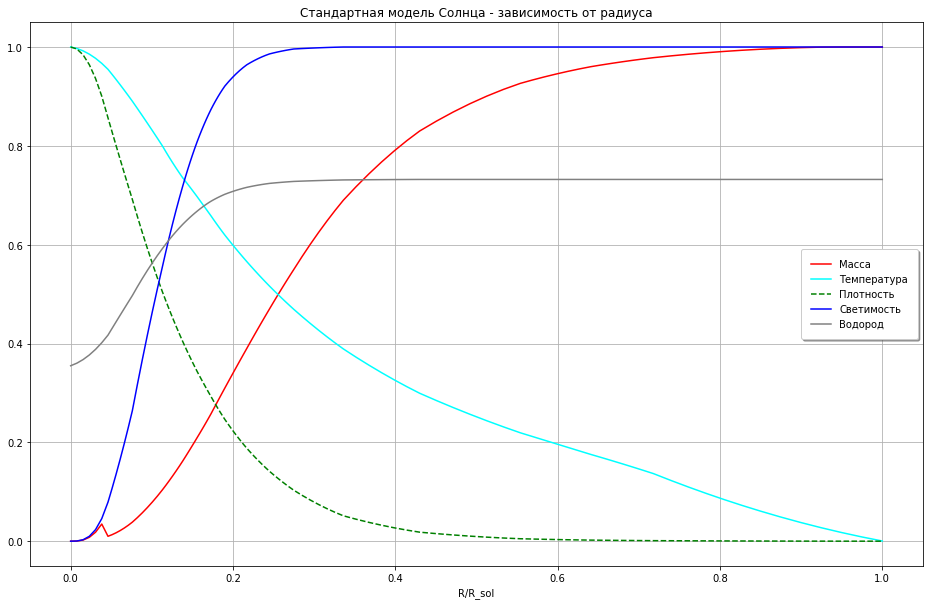

In [33]:
r1 = r/s.R
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, m/s.M, color='red', label='Масса')
plt.plot(r1, t/t[0], color='cyan', label='Температура')
# plt.plot(r1[1:], d1[1:]/d[0], color='green', label='Плотность')
plt.plot(r1, d/d[0], '--', color='green', label='Плотность')
plt.plot(r1, l/s.L, color='blue', label='Светимость')
plt.plot(r1, x, color='gray', label='Водород')
# plt.plot(r1, p1/p1[0], color='black', marker='.', label='Давление')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Стандартная модель Солнца - зависимость от радиуса')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

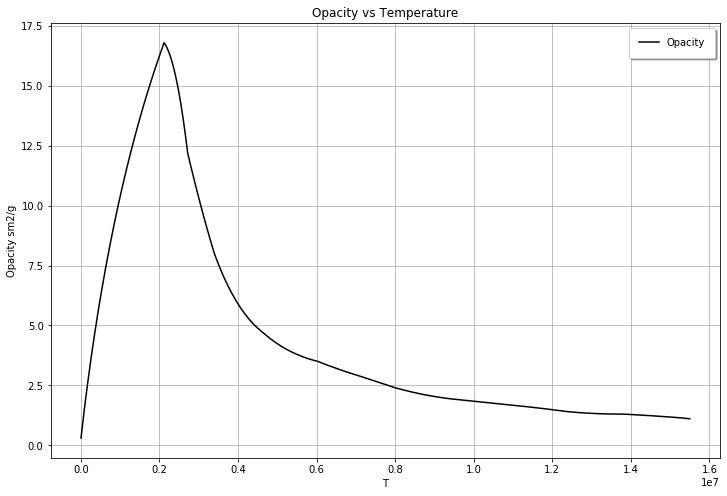

In [12]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.plot(t, k, color='black', label='Opacity')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
#plt.xlim(6, 7.25)
#plt.ylim(0, 20)
plt.xlabel('T')
plt.ylabel('Opacity sm2/g')
plt.title('Opacity vs Temperature')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [35]:
for i in range(2*K):
    print(i, d[i])

0 156.3
1 155.67777777777778
2 153.81111111111113
3 150.70000000000002
4 146.34444444444446
5 140.74444444444444
6 133.9
7 129.46789027833805
8 125.08862444534086
9 120.76220250100846
10 116.48862444534085
11 112.26789027833803
